# Mesh Tutorial 5: Quality, Validation, and Repair

This tutorial covers mesh quality assessment and repair:

1. **Quality Metrics**: Aspect ratio, angles, edge lengths
2. **Mesh Statistics**: Summary of mesh properties
3. **Validation**: Detect common mesh errors
4. **Repair Operations**: Fix mesh problems
5. **Topology Checks**: Watertight and manifold validation

---

## Why Mesh Quality Matters

Poor mesh quality can cause:
- **Numerical instability** in PDE solvers
- **Inaccurate physics** from distorted elements
- **Training issues** for ML models (garbage in, garbage out)
- **Visualization artifacts** from degenerate geometry

In [1]:
import torch

from physicsnemo.mesh import Mesh
from physicsnemo.mesh.primitives.surfaces import sphere_icosahedral
from physicsnemo.mesh.primitives.planar import unit_square
from physicsnemo.mesh.primitives.procedural import lumpy_sphere

## Section 1: Quality Metrics

PhysicsNeMo-Mesh computes per-cell quality metrics that help identify problematic elements.

In [2]:
# Load a mesh
mesh = sphere_icosahedral.load(subdivisions=2)

# Get quality metrics
metrics = mesh.quality_metrics

print("Quality metrics (per cell):")
for key in metrics.keys():
    values = metrics[key]
    if not values.isnan().all():
        print(
            f"  {key}: min={values.min():.4f}, max={values.max():.4f}, mean={values.mean():.4f}"
        )

Quality metrics (per cell):
  aspect_ratio: min=2.3094, max=2.5981, mean=2.4087
  edge_length_ratio: min=1.0000, max=1.1661, mean=1.0622
  min_angle: min=0.9483, max=1.0472, mean=1.0081
  max_angle: min=1.0472, max=1.2450, mean=1.1172
  min_edge_length: min=0.2532, max=0.3249, mean=0.2921
  max_edge_length: min=0.2952, max=0.3249, mean=0.3093
  quality_score: min=0.6606, max=0.7565, mean=0.7201


### Understanding Quality Metrics

| Metric | Ideal Value | Meaning |
|--------|------------|----------|
| `aspect_ratio` | 1.0 | Ratio of max edge to characteristic length |
| `edge_length_ratio` | 1.0 | Ratio of max to min edge length |
| `min_angle` | π/3 (60°) | Smallest interior angle |
| `max_angle` | π/3 (60°) | Largest interior angle |
| `quality_score` | 1.0 | Combined metric (1.0 = perfect equilateral) |

Quality score range: [0.661, 0.757]
Ideal equilateral triangle: 1.0


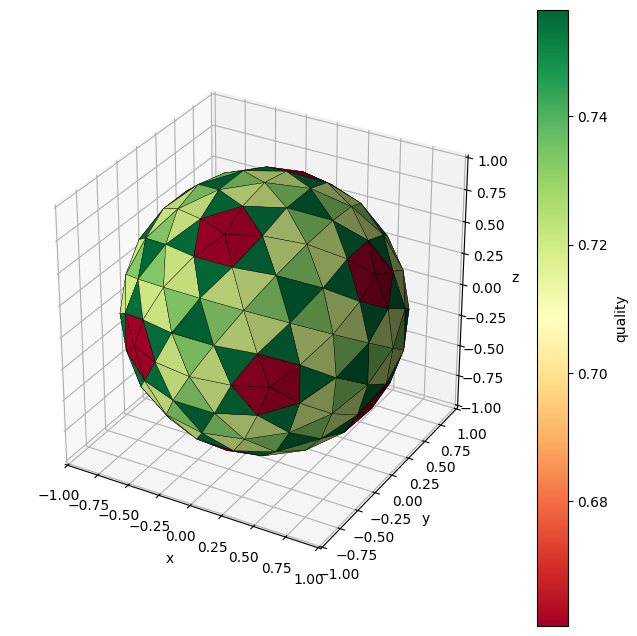

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [3]:
import math

# Visualize quality score
mesh.cell_data["quality"] = metrics["quality_score"]

print(
    f"Quality score range: [{metrics['quality_score'].min():.3f}, {metrics['quality_score'].max():.3f}]"
)
print(f"Ideal equilateral triangle: 1.0")

mesh.draw(cell_scalars="quality", cmap="RdYlGn", show_edges=True, backend="matplotlib")

In [4]:
# Identify poor quality cells
quality_threshold = 0.5
poor_quality_mask = metrics["quality_score"] < quality_threshold
n_poor = poor_quality_mask.sum().item()

print(
    f"Cells with quality < {quality_threshold}: {n_poor} / {mesh.n_cells} ({100 * n_poor / mesh.n_cells:.1f}%)"
)

Cells with quality < 0.5: 0 / 320 (0.0%)


### Comparing Mesh Quality

Let's compare quality between different mesh types.

In [5]:
# Regular mesh (high quality)
regular = sphere_icosahedral.load(subdivisions=3)
regular_quality = regular.quality_metrics["quality_score"].mean()

# Perturbed mesh (lower quality)
lumpy = lumpy_sphere.load(noise_amplitude=0.3, subdivisions=3, seed=42)
lumpy_quality = lumpy.quality_metrics["quality_score"].mean()

print(f"Regular sphere mean quality: {regular_quality:.4f}")
print(f"Lumpy sphere mean quality: {lumpy_quality:.4f}")

Regular sphere mean quality: 0.7238
Lumpy sphere mean quality: 0.6667


Regular sphere (high quality):


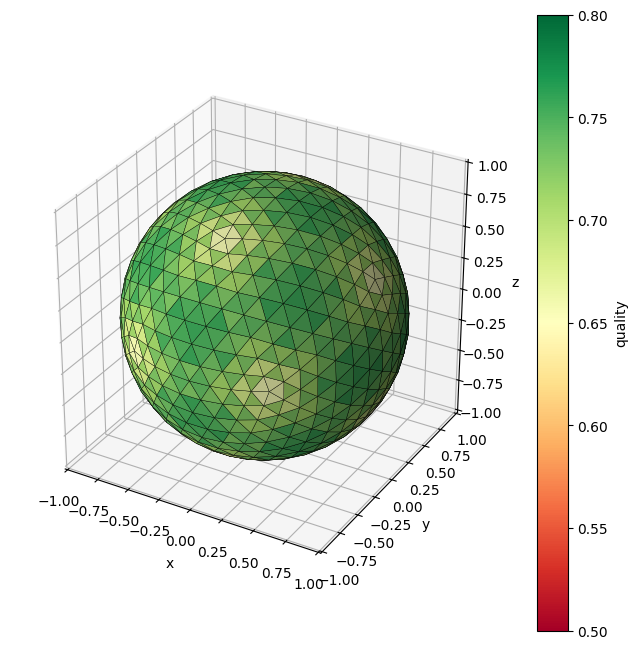

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [6]:
# Visualize quality on both meshes
regular.cell_data["quality"] = regular.quality_metrics["quality_score"]
lumpy.cell_data["quality"] = lumpy.quality_metrics["quality_score"]

print("Regular sphere (high quality):")
regular.draw(
    cell_scalars="quality",
    cmap="RdYlGn",
    vmin=0.5,
    vmax=0.8,
    show_edges=True,
    backend="matplotlib",
)

Lumpy sphere (lower quality - note red/yellow cells where geometry is distorted):


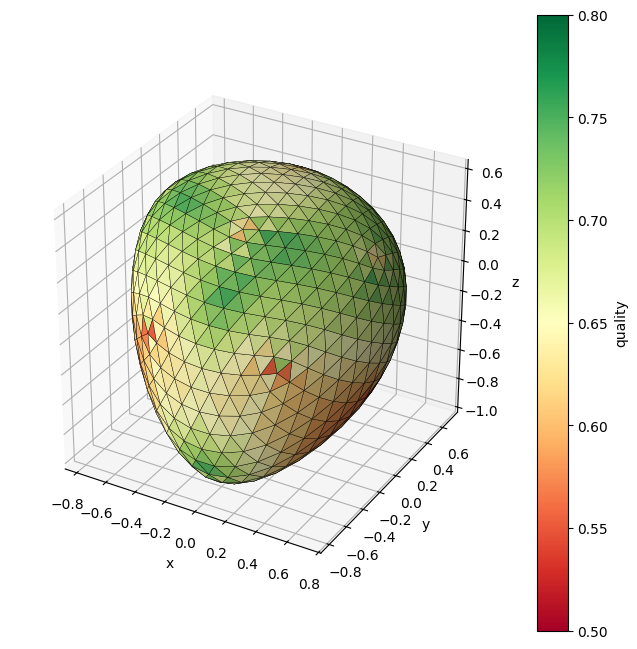

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [7]:
print(
    "Lumpy sphere (lower quality - note red/yellow cells where geometry is distorted):"
)
lumpy.draw(
    cell_scalars="quality",
    cmap="RdYlGn",
    vmin=0.5,
    vmax=0.8,
    show_edges=True,
    backend="matplotlib",
)

## Section 2: Mesh Statistics

Get a comprehensive summary of mesh properties.

In [8]:
mesh = torch.load("assets/bunny.pt", weights_only=False).subdivide(1, "loop")

stats = mesh.statistics

print("Mesh Statistics:")
print("=" * 40)
for key, value in stats.items():
    if isinstance(value, (int, float)):
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
    elif isinstance(value, dict):
        print(f"  {key}:")
        for k, v in value.items():
            if isinstance(v, float):
                print(f"    {k}: {v:.4f}")
            else:
                print(f"    {k}: {v}")

Mesh Statistics:
  n_points: 1594
  n_cells: 3184
  n_manifold_dims: 2
  n_spatial_dims: 3
  n_degenerate_cells: 0
  n_isolated_vertices: 0


## Section 3: Mesh Validation

The `validate()` method checks for common mesh errors.

In [9]:
# Validate a good mesh
mesh = sphere_icosahedral.load(subdivisions=2)
report = mesh.validate()

print("Validation Report (good mesh):")
print(f"  Valid: {report['valid']}")
if report.get("errors"):
    print(f"  Errors: {report['errors']}")
if report.get("warnings"):
    print(f"  Warnings: {report['warnings']}")

Validation Report (good mesh):
  Valid: True


In [10]:
# Create a mesh with some problems
points = torch.tensor(
    [
        [0.0, 0.0],
        [1.0, 0.0],
        [0.5, 1.0],
        [0.5, 0.5],  # Interior point (will be unused)
        [0.0, 0.0],  # Duplicate of point 0
    ]
)

cells = torch.tensor(
    [
        [0, 1, 2],  # Valid triangle
        [0, 0, 1],  # Degenerate (repeated vertex)
    ]
)

bad_mesh = Mesh(points=points, cells=cells)

# Validate
report = bad_mesh.validate(
    check_degenerate_cells=True,
    check_duplicate_vertices=True,
)

print("Validation Report (bad mesh):")
print(f"  Valid: {report['valid']}")
for key, value in report.items():
    if key != "valid":
        print(f"  {key}: {value}")

Validation Report (bad mesh):
  Valid: False
  n_out_of_bounds_cells: 0
  n_duplicate_vertices: 1
  duplicate_vertex_pairs: tensor([[0, 4]])
  n_degenerate_cells: 1
  degenerate_cell_indices: tensor([1])
  degenerate_cell_areas: tensor([0.])


## Section 4: Repair Operations

PhysicsNeMo-Mesh provides several repair operations.

### All-in-One: mesh.clean()

In [11]:
# Create a mesh with duplicate points
points = torch.tensor(
    [
        [0.0, 0.0],
        [1.0, 0.0],
        [0.5, 1.0],
        [0.0, 0.0],  # Duplicate of point 0
        [1.0, 0.0],  # Duplicate of point 1
    ]
)

cells = torch.tensor(
    [
        [0, 1, 2],  # Triangle using original points
        [3, 4, 2],  # Triangle using duplicate points
    ]
)

mesh_with_duplicates = Mesh(points=points, cells=cells)
print(
    f"Before cleaning: {mesh_with_duplicates.n_points} points, {mesh_with_duplicates.n_cells} cells"
)

# Clean the mesh
cleaned = mesh_with_duplicates.clean()
print(f"After cleaning: {cleaned.n_points} points, {cleaned.n_cells} cells")

Before cleaning: 5 points, 2 cells
After cleaning: 3 points, 1 cells


The examples above use small 2D meshes to illustrate the API. See the **Practical Workflow**
section below for a visual before/after demonstration of repair on a 3D mesh.

### Detailed Repair Pipeline

In [12]:
from physicsnemo.mesh.repair import repair_mesh

# Create a mesh with multiple issues
points = torch.tensor(
    [
        [0.0, 0.0],
        [1.0, 0.0],
        [0.5, 1.0],
        [2.0, 2.0],  # Isolated point
        [0.0, 0.0],  # Duplicate
    ]
)

cells = torch.tensor(
    [
        [0, 1, 2],  # Valid
        [0, 0, 1],  # Degenerate
    ]
)

mesh = Mesh(points=points, cells=cells)
print(f"Original: {mesh.n_points} points, {mesh.n_cells} cells")

# Repair with detailed stats
repaired, stats = repair_mesh(
    mesh,
)

print(f"\nRepaired: {repaired.n_points} points, {repaired.n_cells} cells")
print(f"\nRepair statistics:")
for operation, operation_stats in stats.items():
    print(f"  {operation}: {operation_stats}")

Original: 5 points, 2 cells

Repaired: 3 points, 1 cells

Repair statistics:
  degenerates: {'n_zero_area_cells': 1, 'n_duplicate_vertex_cells': 1, 'n_cells_original': 2, 'n_cells_final': 1}
  merge_points: {'n_points_original': 5, 'n_points_final': 4, 'n_duplicates_merged': 1}
  clean: {'n_points_before_merge': 5, 'n_points_after_merge': 4}
  isolated: {'n_isolated_removed': 1, 'n_points_original': 4, 'n_points_final': 3}


## Section 5: Topology Checks

Check if meshes are watertight (closed) or manifold.

In [13]:
# Closed sphere
sphere = sphere_icosahedral.load(subdivisions=2)
print(f"Sphere:")
print(f"  Watertight: {sphere.is_watertight()}")
print(f"  Manifold: {sphere.is_manifold()}")

Sphere:
  Watertight: True
  Manifold: True


Closed sphere (watertight, no boundary):


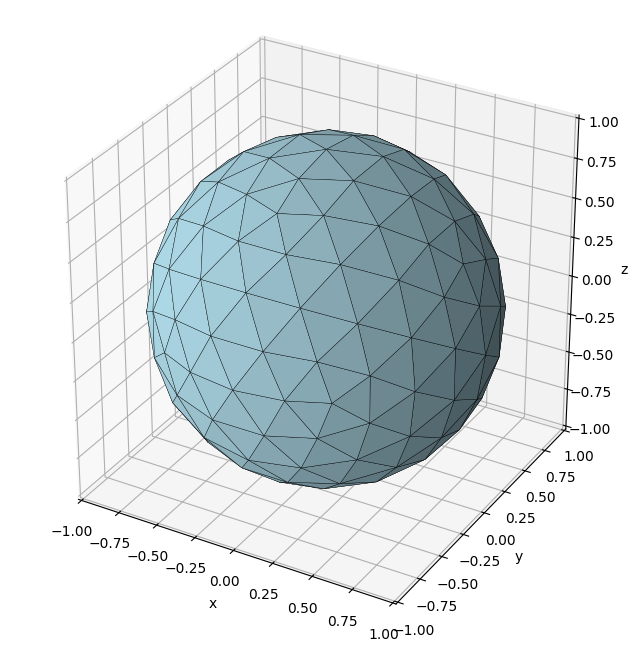

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [14]:
print("Closed sphere (watertight, no boundary):")
sphere.draw(backend="matplotlib")

In [15]:
# Hemisphere (open)
hemisphere = sphere.slice_cells(sphere.cell_centroids[:, 2] > 0)
print(f"Hemisphere:")
print(f"  Watertight: {hemisphere.is_watertight()}")
print(f"  Manifold: {hemisphere.is_manifold()}")

Hemisphere:
  Watertight: False
  Manifold: True


Hemisphere (open boundary visible at the equator):


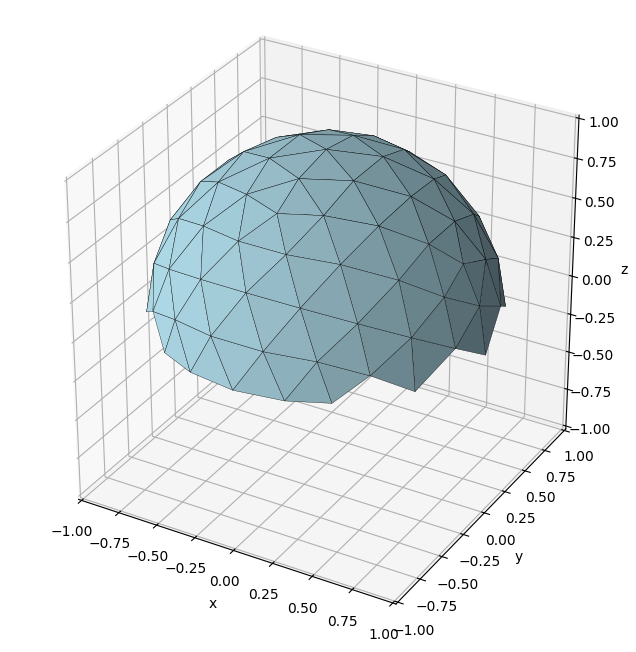

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [16]:
print("Hemisphere (open boundary visible at the equator):")
hemisphere.draw(backend="matplotlib")

In [17]:
# The bunny (should be watertight if cleaned properly)
bunny = torch.load("assets/bunny.pt", weights_only=False)
print(f"Bunny:")
print(f"  Watertight: {bunny.is_watertight()}")
print(f"  Manifold: {bunny.is_manifold()}")

Bunny:
  Watertight: True
  Manifold: True


## Section 6: Practical Workflow

Here's a complete validate-repair-verify workflow on a mesh with real defects.
We'll take the bunny mesh, inject some common problems (duplicate vertices and a
degenerate cell), then walk through detection and repair with before/after visualizations.

In [18]:
# Step 1: Create a mesh with real defects
bunny = torch.load("assets/bunny.pt", weights_only=False)

# Inject 10 duplicate vertices and 1 degenerate cell (zero-area triangle)
bad_points = torch.cat([bunny.points, bunny.points[:10]], dim=0)
bad_cells = torch.cat([bunny.cells, torch.tensor([[0, 0, 1]])], dim=0)
bad_mesh = Mesh(points=bad_points, cells=bad_cells)

print(f"Corrupted mesh: {bad_mesh.n_points} points, {bad_mesh.n_cells} cells")
print(f"  (original bunny had {bunny.n_points} points, {bunny.n_cells} cells)")

# Step 2: Validate - should detect problems
report = bad_mesh.validate(
    check_degenerate_cells=True,
    check_duplicate_vertices=True,
)
print(f"\nValidation: {'PASS' if report['valid'] else 'FAIL'}")
print(f"  Duplicate vertices: {report.get('n_duplicate_vertices', 0)}")
print(f"  Degenerate cells: {report.get('n_degenerate_cells', 0)}")

Corrupted mesh: 410 points, 797 cells
  (original bunny had 400 points, 796 cells)

Validation: FAIL
  Duplicate vertices: 10
  Degenerate cells: 1


Before repair:


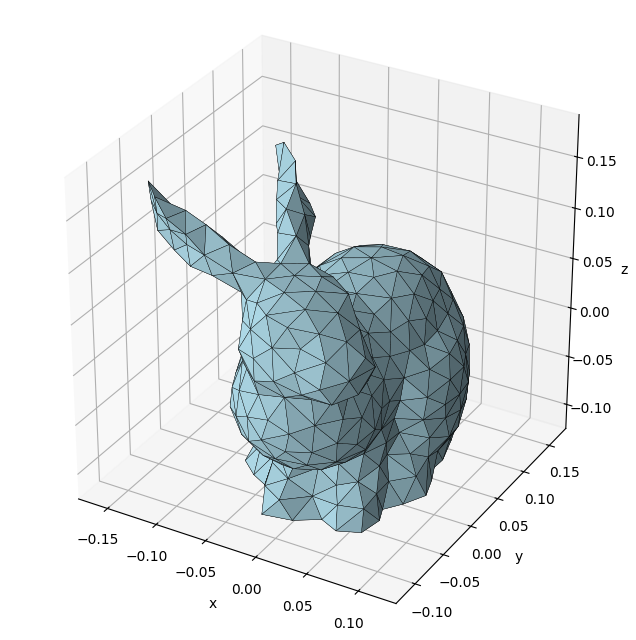

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [19]:
print("Before repair:")
bad_mesh.draw(backend="matplotlib")

In [20]:
# Step 3: Repair
from physicsnemo.mesh.repair import repair_mesh

repaired, stats = repair_mesh(
    bad_mesh,
    merge_points=True,
    remove_degenerates=True,
    remove_isolated=True,
)

print(f"Repair results:")
print(f"  Points: {bad_mesh.n_points} -> {repaired.n_points}")
print(f"  Cells: {bad_mesh.n_cells} -> {repaired.n_cells}")
print(f"\nRepair statistics:")
for operation, op_stats in stats.items():
    print(f"  {operation}: {op_stats}")

Repair results:
  Points: 410 -> 400
  Cells: 797 -> 796

Repair statistics:
  degenerates: {'n_zero_area_cells': 1, 'n_duplicate_vertex_cells': 1, 'n_cells_original': 797, 'n_cells_final': 796}
  merge_points: {'n_points_original': 410, 'n_points_final': 400, 'n_duplicates_merged': 10}
  clean: {'n_points_before_merge': 410, 'n_points_after_merge': 400}
  isolated: {'n_isolated_removed': 0, 'n_points_original': 400, 'n_points_final': 400}


Validation after repair: PASS
Watertight: True
Manifold: True

After repair:


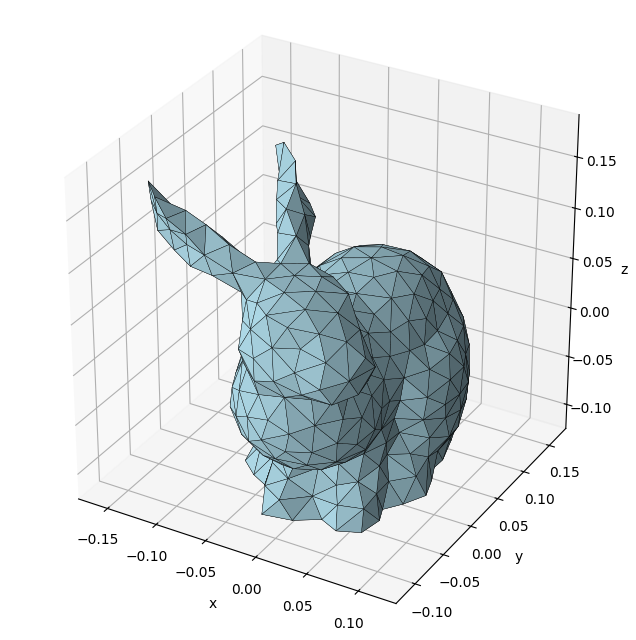

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [21]:
# Step 4: Verify the repaired mesh
report_clean = repaired.validate(
    check_degenerate_cells=True,
    check_duplicate_vertices=True,
)
print(f"Validation after repair: {'PASS' if report_clean['valid'] else 'FAIL'}")
print(f"Watertight: {repaired.is_watertight()}")
print(f"Manifold: {repaired.is_manifold()}")

print("\nAfter repair:")
repaired.draw(backend="matplotlib")

## Summary

In this tutorial, you learned about mesh quality and repair:

1. **Quality Metrics**: `mesh.quality_metrics` for per-cell analysis
2. **Statistics**: `mesh.statistics` for mesh summary
3. **Validation**: `mesh.validate()` to detect errors
4. **Repair**:
   - `mesh.clean()` for all-in-one cleaning
   - `repair_mesh()` for detailed control
5. **Topology**: `is_watertight()` and `is_manifold()`